# Week 5 Discussion: Linear Regression

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
sns.set_style("darkgrid")

/Users/samitakamath/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/samitakamath/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Background

In this discussion session, we, as a group of applied statisticians who are constantly thinking about real-world high-impact applications, are going to explore if we can predict the final exam scores using homework scores using a synthetic (but realistic enough) dataset.

## Dataset

The dataset contains scores of five homework assignments and a final exam 
for 100 (hypothetical) students who took a statistics class from 
last year.
Even though it is early-ish in this quarter and we've only received feedback for the first 3 homeworks for this (hypothetical) class we are taking, we'd like to build a model to predict our final exam scores in this class using only the first few homework scores, so that we are able to forecast our (good) grades early, and enjoy peace of mind.

Specifically, suppose we have observed our first 3 homework scores as 100, 85, and 95, can we predict our final exam scores?

To answer this question, we will start by analyzing the data and fitting a simple regression model using only the score from hw1.
Then we will fit another model using all 5 homework scores, and examine the model closely.

First, let's load the data and plot hw1 scores and final exam scores as a scatterplot.

In [2]:
scores = pd.read_csv("https://raw.githubusercontent.com/stanford-policylab/mse125/main/week_5/scores.csv")

scores

,hw1,hw2,hw3,hw4,hw5,final
0,98,100,71,73,90,78
1,96,82,84,99,48,80
2,100,100,100,93,83,82
3,65,80,40,83,89,59
4,83,97,26,71,100,95
...,...,...,...,...,...,...
95,60,63,70,59,84,64
96,95,97,52,32,43,61
97,80,72,69,100,62,81
98,100,100,100,98,65,97


<AxesSubplot:xlabel='hw1', ylabel='final'>

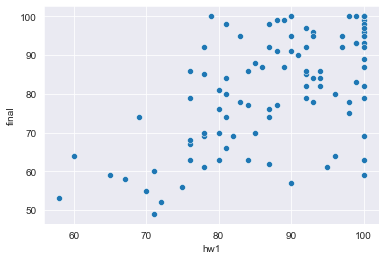

In [3]:
sns.scatterplot(data=scores, x="hw1", y="final")

In the plot, it seems like there is a positive relationship between `hw1` 
and final exam scores. 
Now, we would like to quantitatively measure this (linear) relationship between
the two variables.

# Correlation

To achieve this, we define the correlation coefficient $\rho_{X,Y}$ between two random variable $X$ and $Y$ to be

\begin{align}
\rho_{X,Y} &= \frac{\mathrm{cov}(X, Y)}{\sigma_X\sigma_Y} \\ 
  & = \mathbb{E} \left[ \frac{(X-\mu_X)}{\sigma_X} 
  \frac{(Y-\mu_Y)}{\sigma_Y} \right]
\end{align}

In other words, the definition above shows that we can think of the correlation as the covariance of $X$ and $Y$
scaled by the individual variance of $X$ and $Y$.

The correlation coefficient ranges from -1 to +1, where -1 indicates a perfect
downhill (negative) linear relationship and +1 indicates a perfect uphill
(positive) linear relationship.


To illustrate this, the following plot shows how different values of correlation $\rho$ appear in a scatterplot:

In [4]:
np.random.seed(100)

rhos = [0.99, -.85, .6, .15]
# Initialize results datafram
results = pd.DataFrame({"X":[], "Y":[], "rho":[]})

for rho in rhos:
    X1 = np.random.uniform(0, 1, 50)
    X2 = np.random.uniform(0, 1, 50)
    Y = rho*X1 + ((1 - rho**2)**0.5)*X2
    results = pd.concat([results,\
                  pd.DataFrame({"X":X1 - np.mean(X1), "Y": Y - np.mean(Y), "rho": rho})]
             )

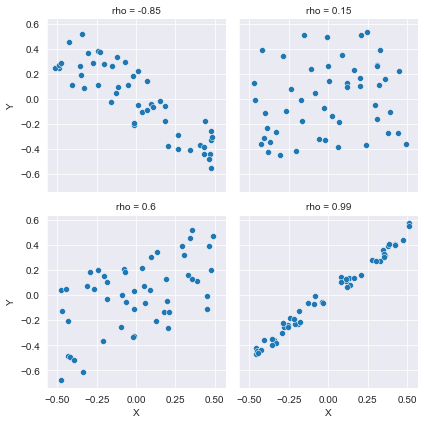

In [5]:
g = sns.FacetGrid(results, col="rho", col_wrap=2)
g.map(sns.scatterplot, "X", "Y")

Empirically, the sample correlation between $X$ and $Y$ from a dataset can be estimated as:

$$
r_{X,Y} = \frac{1}{n}\sum_{i=1}^{n}\frac{X_i - \bar{X}}{\hat{\sigma}_X}\frac{Y_i - \bar{Y}}{\hat{\sigma}_Y}
$$

Which might look a little painful, but lucky for us, Python has several functions we can use to compute the correlation coefficient. One of them is [corr()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) from the pandas library.

**Exercise** : Going back to our original example, calculate the correlation coefficient for `hw1` scores and `final` scores using any Pandas function. 

In [6]:
scores["final"].corr(scores["hw1"])

0.5959981202565628

# Linear Regression

Now, let's model this relationship between `hw1` and final scores using 
simple linear regression.
Recall that simple linear regression is just a model with a
single explanatory variable, where we are trying to find the "best fitting" line
through the points to represent the relationship between the covariate (or the predictor) and the outcome (or the response).

## Review

Under the framework of simple linear regression, we assume that the true 
underlying relationship between $X$ and $Y$ is

$$Y = \beta_0 + \beta_1 X + \varepsilon \quad \textrm{where} \quad
\varepsilon \sim N(0, \sigma^2).$$

Notice that in this model, the randomness is in $\varepsilon$,
which we are using to represent the *error term*, which captures
unobserved factors and/or random variations that influence the value of $Y$.
Due to this unobserved randomness, our linear model will not perfectly predict every possible data point.
Instead, what we predict is the *average* value of $Y$ given the observed $X$.

$$
\hat{Y} = \hat{\beta}_0 + \hat{\beta}_1 X
$$

Within the observed data, $\hat{\beta}_1$ indicates *on average* how much 
$Y$ increased when $X$ increased by 1 unit;
$\hat{\beta}_0$ indicates the average value of $Y$ when $X = 0$. 

<!-- Hence, we can rewrite the model in terms of $\varepsilon$

$$
\varepsilon = 
Y - \beta_0 + \beta_1 X
$$

where $Y$ and $X$ are the observed data, and the regression coefficients 
$\beta_0$ and $\beta_1$ are the parameters we wish to estimate.
We then estimate $\varepsilon$ via the empirical counterpart of the error,
the *residual*:

$$
\hat{\varepsilon} = Y - \hat{\beta}_0 + \hat{\beta}_1 X
$$ -->


## Fitting a simple linear regression model

Now, let's fit a simple linear model on our dataset:

In [7]:
X = sm.add_constant(scores["hw1"])
y = scores["final"]
lm_0 = sm.OLS(y, X).fit()
print(lm_0.summary())

                            OLS Regression Results                            
Dep. Variable:                  final   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     53.99
Date:                Fri, 05 May 2023   Prob (F-statistic):           6.08e-11
Time:                        09:42:35   Log-Likelihood:                -386.01
No. Observations:                 100   AIC:                             776.0
Df Residuals:                      98   BIC:                             781.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1007      9.916      0.918      0.3

/Users/samitakamath/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


### Interpreting model output

*Slope coefficient* : In simple linear regression, the slope coefficient represents the change in the expected value of the dependent variable for a one-unit change in the independent variable. We observe that $\hat{\beta}_1 = 0.82$. This suggests that on average when a student's `hw1` score improved by 1 units, we expect the final exam score will improve by 0.82 points. 

*Constant/ Intercept* : In simple linear regression, the intercept term represents the expected value of the dependent variable when the independent variable is equal to zero. In other words, it represents the value of the dependent variable when none of the independent variables are present or have any effect. In our case, $\hat{\beta}_0 = 9.1$, which means that if a student scored 0 on `hw1`, on average we would expect their final score to be 9.1 points.

The intercept in linear regression may not have a valid interpretation in certain situations for instance in cases where the independent variable can never take on a zero value.

**Exercise**: 
1. Predict the expected score on the final for a student who scored 92 on hw1.

In [8]:
pred = lm_0.predict(np.array([[1, 92]]))[0]
pred

84.63747262623926

2. Recreate the scatter plot showing the relationship between hw1 and final scores, but now also with the fitted regression line. Does the regression line appear to fit the data well? 

<AxesSubplot:xlabel='hw1', ylabel='final'>

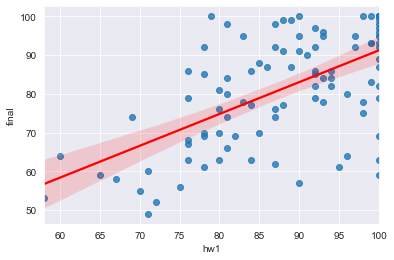

In [9]:
sns.regplot(data=scores, x="hw1", y="final", line_kws={"color": "red"})

# Goodness of Fit

Now we have a working simple linear regression model. But we would still like to know how well our model fits the data overall.

Recall when fitting our regression on a specific dataset, we aim to minimize the
*sum of squared residuals* (or *sum of squared errors (SSE)*):
\begin{align}
  \sum_{i=1}^{n} \hat{\varepsilon}_i^ 2 
    & = \sum_{i=1}^{n} (Y_i - \hat{Y}_i) ^ 2  \\
    & = \sum_{i=1}^{n} \big(Y_i - (\hat{\beta}_0 + \hat{\beta}_1 X_i)\big)^2.
\end{align}

Then we are able to estimate the *root mean square error (RMSE)* or the
*residual standard error* as 

$$
\hat{\varepsilon}_i =
\sqrt{\frac{1}{n}\sum_{i=1}^{n} (Y_i - \hat{Y}_i) ^ 2}.
$$ 

The lower it is, the better---since the goal is to minimize the residuals.

Another common metric for goodness of fit is $R^2$, defined as:

$$
R^2 = 1 - \frac{\sum_{i=1}^{n}(Y_i - \hat{Y}_i)^2}
               {\sum_{i=1}^{n}(Y_i - \bar{Y})^2}.
$$

This metric measures how good the full model (with all covariates) is
compared to the reduced model (with an intercept only), or, how much of the
variation in the dataset can be explained compared to the total variation.
$R^2$ ranges from 0 to 1. In general, the higher $R^2$ is, the better the model
fits the data.

$R^2$ can be found in the regression summary table.

In [10]:
print(lm_0.summary())

                            OLS Regression Results                            
Dep. Variable:                  final   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     53.99
Date:                Fri, 05 May 2023   Prob (F-statistic):           6.08e-11
Time:                        09:42:36   Log-Likelihood:                -386.01
No. Observations:                 100   AIC:                             776.0
Df Residuals:                      98   BIC:                             781.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1007      9.916      0.918      0.3

In [11]:
yhat = lm_0.predict(X)
(np.mean((y - yhat)**2))**0.5

11.486021114447912

$R^2$ is represented by "R-squared" (i.e., 0.355) in the table above. **RMSE** can be calculated as shown above (i.e., 11.486).



## Multiple regression



Can we do better given that we have data for all five homeworks? Now, let's expand our regression to include other homework scores.

In [12]:
X = sm.add_constant(scores[["hw1", "hw2", "hw3", "hw4", "hw5"]])
y = scores["final"]
lm_5 = sm.OLS(y, X).fit()
print(lm_5.summary())

                            OLS Regression Results                            
Dep. Variable:                  final   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     16.92
Date:                Fri, 05 May 2023   Prob (F-statistic):           6.74e-12
Time:                        09:42:36   Log-Likelihood:                -375.86
No. Observations:                 100   AIC:                             763.7
Df Residuals:                      94   BIC:                             779.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7502     11.099     -0.158      0.8

/Users/samitakamath/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [13]:
yhat = lm_5.predict(X)
(np.mean((y - yhat)**2))**0.5

10.377363001806671

From the summary table above, both $R^2$ (0.474) and **RMSE** (10.37) indicate that our multiple
linear regression fits the data better than the simple linear regression.

### Interpreting model output

*Coefficients* : In multiple linear regression, the slope coefficients represent the change in the expected value of the dependent variable for a one-unit change in the corresponding independent variable, **while holding all other independent variables constant**. 

We observe that $\hat{\beta}_1 = 0.36$. This suggests that on average when a student's `hw1` score improves by 1 unit, we expect the final exam score will improve by 0.36 points **holding other homework scores constant**. 

Note that the estimated value of $\beta$ is different for each homework,
suggesting different levels of association between homework
scores and the final exam score.
This could be due to a variety of reasons.  For example, it's possible that questions on the final exam focus more on the 
knowledge covered in the first homework. 
It's difficult to conclude.
We would have to examine the data closely with more background knowledge 
regarding the data in order to answer this question.

*Constant/ Intercept* : In multiple linear regression, the intercept term represents the expected value of the dependent variable when all independent variables are equal to zero. In other words, it represents the value of the dependent variable when none of the independent variables are present or have any effect. 

In our case, $\hat{\beta}_0 = -1.75$. However, we know that `final` scores cannot be negative. This is a great example of when an intercept does not have a valid interpretation. 

**Exercise**:
1. Try fitting multiple linear regression models with k=2,3,4 predictors.   
    b. Considering all the models we've fitted, which one do you think has the greatest predictive power?   
    b. What does this tell us about which homework scores are most important in predicting final scores?   
    c. Write down the interpretation of the coefficients of the best model.  

*Note on solution*: This solution only attempts a few combinations of the homework scores on the basis that we're interested in using the earlier homeworks to predict final performance. There are other possible combinations you could try (which might lead to different conclusions). 

There are techniques called "subset selection" which allow you to test all combinations of variables in a regression model.

#### k=2

In [14]:
X = sm.add_constant(scores[["hw1", "hw2"]])
y = scores["final"]
lm_2 = sm.OLS(y, X).fit()
print(lm_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  final   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     29.46
Date:                Fri, 05 May 2023   Prob (F-statistic):           1.01e-10
Time:                        09:42:36   Log-Likelihood:                -384.22
No. Observations:                 100   AIC:                             774.4
Df Residuals:                      97   BIC:                             782.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4134     11.277     -0.125      0.9

/Users/samitakamath/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [15]:
yhat = lm_2.predict(X)
(np.mean((y - yhat)**2))**0.5

11.282582965990278

#### k=3

In [16]:
X = sm.add_constant(scores[["hw1", "hw2", "hw3"]])
y = scores["final"]
lm_3 = sm.OLS(y, X).fit()
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  final   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     26.05
Date:                Fri, 05 May 2023   Prob (F-statistic):           2.05e-12
Time:                        09:42:36   Log-Likelihood:                -378.17
No. Observations:                 100   AIC:                             764.3
Df Residuals:                      96   BIC:                             774.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6825     10.768      0.342      0.7

/Users/samitakamath/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [17]:
yhat = lm_3.predict(X)
(np.mean((y - yhat)**2))**0.5

10.62016118119779

#### k=4

In [18]:
X = sm.add_constant(scores[["hw1", "hw2", "hw3", "hw4"]])
y = scores["final"]
lm_4 = sm.OLS(y, X).fit()
print(lm_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  final   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     20.72
Date:                Fri, 05 May 2023   Prob (F-statistic):           2.65e-12
Time:                        09:42:36   Log-Likelihood:                -376.58
No. Observations:                 100   AIC:                             763.2
Df Residuals:                      95   BIC:                             776.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7533     10.711      0.164      0.8

/Users/samitakamath/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [19]:
yhat = lm_4.predict(X)
(np.mean((y - yhat)**2))**0.5

10.453114839885785

We observe that as the number of predictors increase, RMSE falls and R-squared increases. This is an expected result. However, after `k=3`, the increases in R-squared and decreases in RMSE plateau. Hence, if we wanted to make predictions about the final score earlier in the quarter, it would be reasonable to choose the model with the first 3 homework scores as opposed to waiting until all 5 homework scores were out. Later in the quarter, we'll also learn about overfitting i.e., how creating a model with too much complexity and too many predictors might perform well on the training set but poorly on an unseen test set.

#### Model coefficient interpretation
The coefficients of the `k=3` model tell us that for a 1-unit increase in:  
- hw1 scores, we can expect on average a 0.4 unit increase in final scores holding other homework scores constant
- hw2 scores, we can expect on average a 0.3 unit increase in final scores holding other homework scores constant
- hw3 scores, we can expect on average a 0.2 unit increase in final scores holding other homework scores constant

Hence, we observe a decreasing effect on final scores as we go later in the quarter. This confirms our initial hypothesis that earlier homework scores might be more important in predicting final scores.

2. Now we go back to our original question: when we have observed our first 3 homework scores as **100, 85, and 95,** can we predict our final exam scores?

In [20]:
pred = lm_3.predict(np.array([[1, 100, 85, 95]]))[0]
pred

91.16204307130164